## Credit Card Kaggle Anamoly Detection

### Context
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

### Content
The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

### Inspiration
Identify fraudulent credit card transactions.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

### Acknowledgements
The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available on https://www.researchgate.net/project/Fraud-detection-5 and the page of the DefeatFraud project

In [1]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]


In [ ]:
!pip install -U -q PyDrive

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
  
  
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
link =   'https://drive.google.com/file/d/1y2g5lIU9bLcDBoafJXD9ORKQoAm4hCqj/view?usp=sharing'

import pandas as pd



In [5]:
# to get the id part of the file
id = link.split("/")[-2]

downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('primary_account(2).csv')

data = pd.read_csv('primary_account(2).csv', sep = ',')
 

Exploratory Data Analysis

In [ ]:
 
data.head()

,id,amount,available_balance,primary_account_id,Class
0,15,133,1000.0,11,0
1,17,10,990.0,11,1
2,19,170,6545.0,11,0
3,21,10,6535.0,11,1
4,23,100,6435.0,11,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  19 non-null     int64  
 1   amount              19 non-null     int64  
 2   available_balance   19 non-null     float64
 3   primary_account_id  19 non-null     int64  
 4   Class               19 non-null     int64  
dtypes: float64(1), int64(4)
memory usage: 888.0 bytes


In [6]:
data.describe()

,id,amount,available_balance,primary_account_id,Class
count,19.000000,19.000000,19.000000,19.000000,19.000000
mean,37.736842,49.368421,3720.105263,10.210526,0.210526
std,14.328845,50.993693,3001.704495,11.291978,0.418854
min,15.000000,5.000000,10.000000,1.000000,0.000000
25%,25.500000,10.000000,967.500000,2.000000,0.000000
50%,39.000000,10.000000,6391.000000,11.000000,0.000000
75%,47.500000,83.500000,6461.000000,11.000000,0.000000
max,61.000000,170.000000,6547.000000,53.000000,1.000000


In [7]:
data.shape

(19, 5)

## Exploratory Data Analysis

In [ ]:
data.isnull().values.any()

False

Text(0, 0.5, 'Frequency')

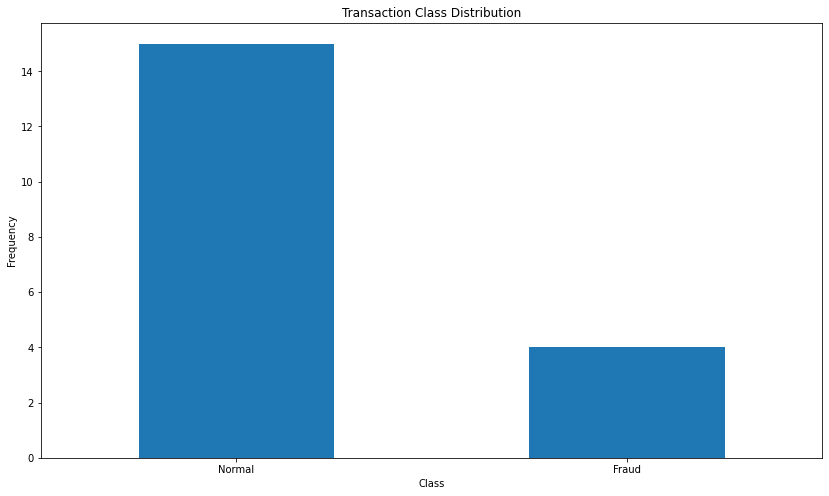

In [ ]:
count_classes = pd.value_counts(data['Class'], sort = True)

count_classes.plot(kind = 'bar', rot=0)

plt.title("Transaction Class Distribution")

plt.xticks(range(2), LABELS)

plt.xlabel("Class")

plt.ylabel("Frequency")

**DATA PREPROCESSING**

In [8]:
data.dtypes == object

id                    False
amount                False
available_balance     False
primary_account_id    False
Class                 False
dtype: bool

In [9]:
data.columns

Index(['id', 'amount', 'available_balance', 'primary_account_id', 'Class'], dtype='object')

In [12]:
data.std()

id                      14.328845
amount                  50.993693
available_balance     3001.704495
primary_account_id      11.291978
Class                    0.418854
dtype: float64

In [13]:
data.isnull().sum()
# To check whether the dataset has missing values 

id                    0
amount                0
available_balance     0
primary_account_id    0
Class                 0
dtype: int64

In [14]:
data["Class"].value_counts()

0    15
1     4
Name: Class, dtype: int64

In [15]:
from sklearn import preprocessing 

In [17]:
## Get the Fraud and the normal dataset 

fraud = data[data['Class']==1]

normal = data[data['Class']==0]

In [18]:
print(fraud.shape,normal.shape)

(4, 5) (15, 5)


In [19]:
## We need to analyze more amount of information from the transaction data
#How different are the amount of money used in different transaction classes?
fraud.amount.describe()

count     4.000000
mean     23.000000
std      29.427878
min       5.000000
25%       8.750000
50%      10.000000
75%      24.250000
max      67.000000
Name: amount, dtype: float64

In [20]:
normal.amount.describe()

count     15.000000
mean      56.400000
std       53.908388
min        5.000000
25%       10.000000
50%       55.000000
75%      100.000000
max      170.000000
Name: amount, dtype: float64

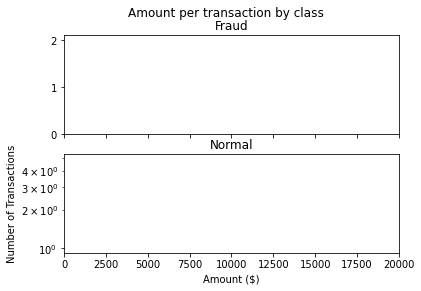

In [21]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')
bins = 50
ax1.hist(fraud.amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(normal.amount, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

AttributeError: ignored

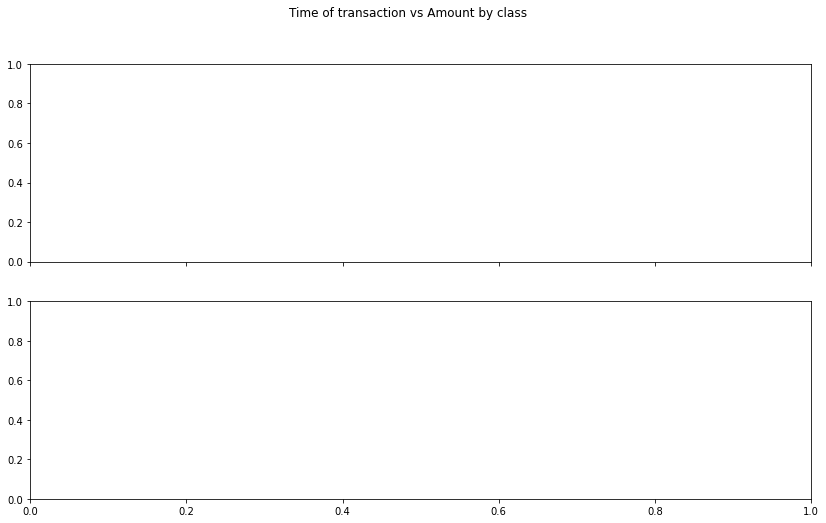

In [ ]:
# We Will check Do fraudulent transactions occur more often during certain time frame ? Let us find out with a visual representation.

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')
ax1.scatter(Fraud.Time, Fraud.amount)
ax1.set_title('Fraud')
ax2.scatter(Normal.Time, Normal.amount)
ax2.set_title('Normal')
plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

In [23]:
## Take some sample of the data

data1= data.sample(frac = 1,random_state=1)

data1.shape

(19, 5)

In [24]:
data.shape

(19, 5)

Splitting the data into Features & Targets

In [27]:
X = data.drop(columns='Class', axis=1)
Y = data['Class']

In [28]:
X

,id,amount,available_balance,primary_account_id
0,15,133,1000.0,11
1,17,10,990.0,11
2,19,170,6545.0,11
3,21,10,6535.0,11
4,23,100,6435.0,11
5,28,55,6446.0,11
6,33,10,6456.0,11
7,35,10,6466.0,11
8,37,67,6399.0,11
9,39,8,6391.0,11


In [29]:
Y

0     0
1     1
2     0
3     1
4     0
5     0
6     0
7     0
8     1
9     0
10    0
11    0
12    0
13    0
14    1
15    0
16    0
17    0
18    0
Name: Class, dtype: int64

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=2)

In [32]:
print(X.shape, X_train.shape, X_test.shape)

(19, 4) (15, 4) (4, 4)


In [33]:
#Determine the number of fraud and valid transactions in the dataset

Fraud = data1[data1['Class']==1]   

Valid = data1[data1['Class']==0]

outlier_fraction = len(Fraud)/float(len(Valid))

In [34]:
print(outlier_fraction)

print("Fraud Cases : {}".format(len(Fraud)))

print("Valid Cases : {}".format(len(Valid)))

0.26666666666666666
Fraud Cases : 4
Valid Cases : 15


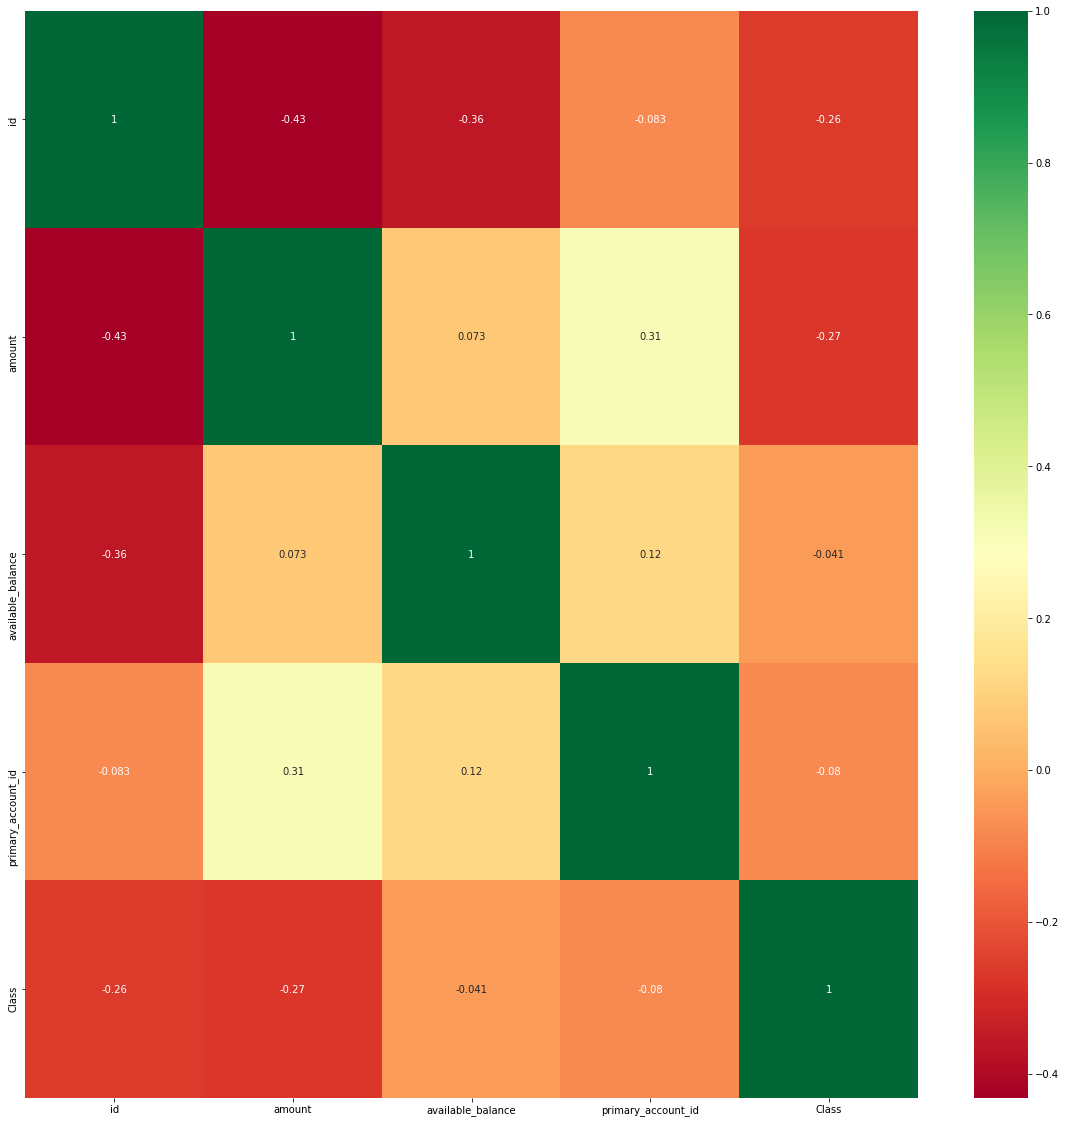

In [ ]:
## Correlation
import seaborn as sns
#get correlations of each features in dataset
corrmat = data1.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [37]:
#Create independent and Dependent Features
columns = data1.columns.tolist()
# Filter the columns to remove data we do not want 
columns = [c for c in columns if c not in ["Class"]]
# Store the variable we are predicting 
target = "Class"
# Define a random state 
state = np.random.RandomState(42)
X = data1[columns]
Y = data1[target]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
# Print the shapes of X & Y
print(X.shape)
print(Y.shape)

(19, 4)
(19,)


# Splitting up the data Randomly 

## Model Prediction





Now it is time to start building the model .The types of algorithms we are going to use to try to do anomaly detection on this dataset are as follows

### Isolation Forest Algorithm :
One of the newest techniques to detect anomalies is called Isolation Forests. The algorithm is based on the fact that anomalies are data points that are few and different. As a result of these properties, anomalies are susceptible to a mechanism called isolation.

This method is highly useful and is fundamentally different from all existing methods. It introduces the use of isolation as a more effective and efficient means to detect anomalies than the commonly used basic distance and density measures. Moreover, this method is an algorithm with a low linear time complexity and a small memory requirement. It builds a good performing model with a small number of trees using small sub-samples of fixed size, regardless of the size of a data set.

Typical machine learning methods tend to work better when the patterns they try to learn are balanced, meaning the same amount of good and bad behaviors are present in the dataset.

How Isolation Forests Work
The Isolation Forest algorithm isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature. The logic argument goes: isolating anomaly observations is easier because only a few conditions are needed to separate those cases from the normal observations. On the other hand, isolating normal observations require more conditions. Therefore, an anomaly score can be calculated as the number of conditions required to separate a given observation.

The way that the algorithm constructs the separation is by first creating isolation trees, or random decision trees. Then, the score is calculated as the path length to isolate the observation.


### Local Outlier Factor(LOF) Algorithm
The LOF algorithm is an unsupervised outlier detection method which computes the local density deviation of a given data point with respect to its neighbors. It considers as outlier samples that have a substantially lower density than their neighbors.

The number of neighbors considered, (parameter n_neighbors) is typically chosen 1) greater than the minimum number of objects a cluster has to contain, so that other objects can be local outliers relative to this cluster, and 2) smaller than the maximum number of close by objects that can potentially be local outliers. In practice, such informations are generally not available, and taking n_neighbors=20 appears to work well in general.

In [39]:
type(classifiers)

dict

In [46]:
model = IsolationForest()   #de meme pour Local Outlier Factor(LOF) Algorithm

In [47]:
model.fit(X_train, Y_train)

IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

In [49]:
# accuracy on training data
X_train_prediction = model.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, Y_train)

In [56]:
print('Accuracy on Training data : ', training_data_accuracy)

Accuracy on Training data :  0.06666666666666667


In [57]:
# accuracy on test data
X_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction, Y_test)

In [58]:
print('Accuracy score on Test Data : ', test_data_accuracy)

Accuracy score on Test Data :  0.25


In [59]:
y_pred = np.array(model.predict(X_test))
y = np.array(Y_test )

In [60]:
    print("Accuracy Score :")
    print(accuracy_score(Y_test,y_pred))
    print("Classification Report :")
    print(classification_report(Y_test,y_pred))

Accuracy Score :
0.25
Classification Report :
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00         3
           1       1.00      1.00      1.00         1

    accuracy                           0.25         4
   macro avg       0.33      0.33      0.33         4
weighted avg       0.25      0.25      0.25         4



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
##Define the outlier detection methods

classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X), 
                                       contamination=outlier_fraction,random_state=state, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=outlier_fraction),
    "Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05, 
                                       max_iter=-1 )
   
}

In [68]:
n_outliers = len(Fraud)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Support Vector Machine":
        clf.fit(X)
        y_pred = clf.predict(X)
    else:    
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != Y).sum()
    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(Y,y_pred))
    print("Classification Report :")
    print(classification_report(Y,y_pred))

Isolation Forest: 7
Accuracy Score :
0.631578947368421
Classification Report :
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.20      0.25      0.22         4

    accuracy                           0.63        19
   macro avg       0.49      0.49      0.49        19
weighted avg       0.66      0.63      0.65        19

Local Outlier Factor: 7
Accuracy Score :
0.631578947368421
Classification Report :
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.20      0.25      0.22         4

    accuracy                           0.63        19
   macro avg       0.49      0.49      0.49        19
weighted avg       0.66      0.63      0.65        19

Support Vector Machine: 8
Accuracy Score :
0.5789473684210527
Classification Report :
              precision    recall  f1-score   support

           0       0.89      0.53      0.67

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_lof.py:259: UserWarning: n_neighbors (20) is greater than the total number of samples (19). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


#### Observations :
- Isolation Forest detected 73 errors versus Local Outlier Factor detecting 97 errors vs. SVM detecting 8516 errors
- Isolation Forest has a 99.74% more accurate than LOF of 99.65% and SVM of 70.09
- When comparing error precision & recall for 3 models , the Isolation Forest performed much better than the LOF as we can see that the detection of fraud cases is around 27 % versus LOF detection rate of just 2 % and SVM of 0%.
- So overall Isolation Forest Method performed much better in determining the fraud cases which is around 30%.
- We can also improve on this accuracy by increasing the sample size or use deep learning algorithms however at the cost of computational expense.We can also use complex anomaly detection models to get better accuracy in determining more fraudulent cases